In [1]:
# Install necessary packages
!pip install datasets scikit-learn sentence-transformers matplotlib umap-learn pandas seaborn hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import time
import gc
import os

# Memory management function
def memory_status():
    """Print current memory usage status"""
    import psutil
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()

    # Convert to GB for readability
    memory_gb = memory_info.rss / (1024 ** 3)
    print(f"Current memory usage: {memory_gb:.2f} GB")
    return memory_gb

# Force garbage collection
def force_gc():
    """Force garbage collection to free memory"""
    collected = gc.collect()
    memory_status()
    print(f"Garbage collected: {collected} objects")

# Data processing and ML libraries
from datasets import load_dataset
import hdbscan
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import umap

# Set random seed for reproducibility
np.random.seed(42)

# Initial memory check
memory_status()

Current memory usage: 1.41 GB


1.4091644287109375

In [3]:
# Text cleaning function with memory optimization
def clean_text_list(text_list, batch_size=5000):
    """Clean text with batch processing to save memory"""
    print("Cleaning text data...")

    # Process in batches
    cleaned_list = []
    total_batches = (len(text_list) + batch_size - 1) // batch_size

    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i+batch_size]

        # Handle None values and convert all to strings
        batch_cleaned = [str(text) if text is not None else "" for text in batch]

        # Apply cleaning to batch
        for j, text in enumerate(batch_cleaned):
            # Remove Asian characters
            text = re.sub(r'[\u4e00-\u9fff]+', '', text)
            # Remove URLs
            text = re.sub(r'http\S+|www\S+', '', text)
            # Remove RT prefix
            text = re.sub(r'RT : ', '', text)
            # Replace & with 'and'
            text = re.sub(r'&', 'and', text)
            # Handle special characters and quotes
            text = re.sub(r'â€™', '\'', text)
            text = re.sub(r'["&;]', '', text)
            text = re.sub(r'', '', text)  # Zero-width space
            # Remove .X or .x
            text = re.sub(r'\.[Xx]', '', text)
            # Normalize multiple dots to ellipsis
            text = re.sub(r'\.\.+', '...', text)
            # Remove standalone @ and pipe symbols
            text = re.sub(r'@|\|', '', text)
            # Normalize spaces
            text = re.sub(r'\s+', ' ', text).strip()
            # Convert to lowercase
            text = text.lower()
            # Remove wallet addresses
            wallet_pattern = r'0x[a-fA-F0-9]{40}|[13][a-km-zA-HJ-NP-Z1-9]{25,34}'
            text = re.sub(wallet_pattern, '', text)
            batch_cleaned[j] = text

        cleaned_list.extend(batch_cleaned)

        # Status update
        if (i // batch_size) % 5 == 0:
            print(f"Processed batch {i // batch_size + 1}/{total_batches}")
            force_gc()  # Free memory after processing batches

    return cleaned_list

# Function to map sentiment labels (for later evaluation)
def sentiment_map(text):
    if 'Bullish' in text:
        return 0
    elif 'Neutral' in text:
        return 1
    else:
        return 2  # Bearish

In [4]:
# Load dataset with memory management
print("Loading dataset...")
start_time = time.time()

data = load_dataset("StephanAkkerman/financial-tweets-crypto")
train_dataset = data['train']
train_dataset = train_dataset.filter(lambda data: data['sentiment'] is not None)

memory_status()

# Process the sentiment labels separately to save memory
true_labels = [sentiment_map(sent) for sent in train_dataset['sentiment']]
force_gc()  # Free memory

# Clean texts with batch processing
texts = clean_text_list(train_dataset['description'])
force_gc()  # Free memory

# Clear the original dataset from memory
train_dataset = None
data = None
force_gc()  # Free memory

print(f"Total samples: {len(texts)}")
print(f"Dataset loaded and processed in {time.time() - start_time:.2f} seconds")

# Check sentiment distribution
sentiment_counts = Counter(true_labels)
print("\nSentiment distribution in original dataset:")
for sentiment, count in sorted(sentiment_counts.items()):
    sentiment_name = ["Bullish", "Neutral", "Bearish"][sentiment]
    print(f"{sentiment_name}: {count} samples ({count/len(true_labels)*100:.2f}%)")

memory_status()

Loading dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

crypto.csv:   0%|          | 0.00/54.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/57935 [00:00<?, ? examples/s]

Filter:   0%|          | 0/57935 [00:00<?, ? examples/s]

Current memory usage: 1.56 GB
Current memory usage: 1.56 GB
Garbage collected: 95053 objects
Cleaning text data...
Processed batch 1/10
Current memory usage: 1.56 GB
Garbage collected: 0 objects
Processed batch 6/10
Current memory usage: 1.56 GB
Garbage collected: 0 objects
Current memory usage: 1.56 GB
Garbage collected: 0 objects
Current memory usage: 1.51 GB
Garbage collected: 0 objects
Total samples: 48692
Dataset loaded and processed in 24.69 seconds

Sentiment distribution in original dataset:
Bullish: 29276 samples (60.12%)
Neutral: 10329 samples (21.21%)
Bearish: 9087 samples (18.66%)
Current memory usage: 1.51 GB


1.5074005126953125

In [5]:
# Sample the data to fit memory constraints
def sample_data(texts, true_labels, sample_size=25000):
    """Sample the data to work within memory constraints"""
    print(f"Sampling {sample_size} examples from {len(texts)} total...")

    if len(texts) > sample_size:
        # Use stratified sampling to maintain class distribution
        indices = []
        labels = np.array(true_labels)

        for label in np.unique(labels):
            # Get indices for this label
            label_indices = np.where(labels == label)[0]

            # Calculate proportional sample size for this label
            label_sample_size = int(sample_size * len(label_indices) / len(labels))

            # Sample indices for this label
            sampled = np.random.choice(label_indices, size=label_sample_size, replace=False)
            indices.extend(sampled)

        # Shuffle the indices
        np.random.shuffle(indices)

        # Limit to exactly sample_size
        indices = indices[:sample_size]

        # Sample the data
        sampled_texts = [texts[i] for i in indices]
        sampled_labels = [true_labels[i] for i in indices]

        print(f"Sampled {len(sampled_texts)} examples")

        # Check sentiment distribution in sample
        sentiment_counts = Counter(sampled_labels)
        print("Sentiment distribution in sample:")
        for sentiment, count in sorted(sentiment_counts.items()):
            sentiment_name = ["Bullish", "Neutral", "Bearish"][sentiment]
            print(f"{sentiment_name}: {count} samples ({count/len(sampled_labels)*100:.2f}%)")

        return sampled_texts, sampled_labels
    else:
        return texts, true_labels

# Sample the data
texts, true_labels = sample_data(texts, true_labels)
force_gc()  # Free memory

Sampling 25000 examples from 48692 total...
Sampled 24999 examples
Sentiment distribution in sample:
Bullish: 15031 samples (60.13%)
Neutral: 5303 samples (21.21%)
Bearish: 4665 samples (18.66%)
Current memory usage: 1.51 GB
Garbage collected: 0 objects


In [6]:
# Extract features using Sentence Transformers with memory optimization
def extract_features(texts, model_name='all-MiniLM-L6-v2', batch_size=128):
    print(f"Extracting features using {model_name}...")
    start_time = time.time()

    model = SentenceTransformer(model_name)

    # Process in smaller batches to avoid memory issues
    embeddings = []

    total_batches = (len(texts) + batch_size - 1) // batch_size
    for i in range(0, len(texts), batch_size):
        if (i // batch_size) % 10 == 0:
            print(f"Processing batch {i//batch_size + 1}/{total_batches}...")
            memory_status()

        batch = texts[i:i+batch_size]
        batch_embeddings = model.encode(batch, show_progress_bar=False)
        embeddings.append(batch_embeddings)

        # Clear batch from memory
        del batch
        if (i // batch_size) % 10 == 0:
            force_gc()

    # Combine all batches
    print("Combining batches...")
    embeddings = np.vstack(embeddings)

    print(f"Feature extraction completed in {time.time() - start_time:.2f} seconds")
    print(f"Embedding shape: {embeddings.shape}")

    return embeddings

# Clear the texts from memory after feature extraction
embeddings = extract_features(texts)
del texts
force_gc()  # Free memory

# Normalize embeddings (in-place to save memory)
print("Normalizing embeddings...")
norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
embeddings = embeddings / norms
del norms
force_gc()  # Free memory

memory_status()

Extracting features using all-MiniLM-L6-v2...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Processing batch 1/196...
Current memory usage: 1.54 GB
Current memory usage: 1.72 GB
Garbage collected: 367 objects
Processing batch 11/196...
Current memory usage: 1.92 GB
Current memory usage: 1.92 GB
Garbage collected: 0 objects
Processing batch 21/196...
Current memory usage: 1.99 GB
Current memory usage: 2.02 GB
Garbage collected: 0 objects
Processing batch 31/196...
Current memory usage: 2.10 GB
Current memory usage: 2.10 GB
Garbage collected: 0 objects
Processing batch 41/196...
Current memory usage: 2.13 GB
Current memory usage: 2.13 GB
Garbage collected: 0 objects
Processing batch 51/196...
Current memory usage: 2.24 GB
Current memory usage: 2.24 GB
Garbage collected: 0 objects
Processing batch 61/196...
Current memory usage: 2.27 GB
Current memory usage: 2.27 GB
Garbage collected: 0 objects
Processing batch 71/196...
Current memory usage: 2.32 GB
Current memory usage: 2.32 GB
Garbage collected: 0 objects
Processing batch 81/196...
Current memory usage: 2.35 GB
Current memory

2.3662109375

In [7]:
# Reduce dimensionality with UMAP for better clustering
def reduce_dimensions(embeddings, n_components=20, random_state=42):
    print(f"Reducing dimensions to {n_components} components...")
    start_time = time.time()

    # Use UMAP for dimensionality reduction
    # Lower n_neighbors and min_dist for memory efficiency
    reducer = umap.UMAP(
        n_components=n_components,
        random_state=random_state,
        n_neighbors=10,  # Lower value for memory efficiency
        min_dist=0.1,
        metric='euclidean',
        low_memory=True  # Enable low memory mode
    )
    reduced_embeddings = reducer.fit_transform(embeddings)

    print(f"Dimensionality reduction completed in {time.time() - start_time:.2f} seconds")
    print(f"Reduced embedding shape: {reduced_embeddings.shape}")

    return reduced_embeddings

# Reduce dimensions
reduced_embeddings = reduce_dimensions(embeddings, n_components=20)
del embeddings
force_gc()  # Free memory

memory_status()

Reducing dimensions to 20 components...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Dimensionality reduction completed in 68.20 seconds
Reduced embedding shape: (24999, 20)
Current memory usage: 2.32 GB
Garbage collected: 128784 objects
Current memory usage: 2.32 GB


2.3170013427734375

In [8]:
# Implement HDBSCAN Clustering with memory optimization
def run_hdbscan(embeddings, min_cluster_size=15, min_samples=5):
    print(f"Running HDBSCAN with min_cluster_size={min_cluster_size}, min_samples={min_samples}...")
    start_time = time.time()
    memory_status()

    # Initialize and fit the model with memory-efficient settings
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric='euclidean',
        cluster_selection_method='eom',  # More conservative than 'leaf'
        alpha=1.0,  # Conservative cluster selection
        approx_min_span_tree=True,  # Memory optimization
        gen_min_span_tree=False,  # Memory optimization - don't store the full tree
        algorithm='best',  # Let it choose the best algorithm
        core_dist_n_jobs=2  # Limit parallelism to save memory
    )

    # Fit the model
    print("Fitting HDBSCAN model...")
    cluster_labels = clusterer.fit_predict(embeddings)

    # Count samples in each cluster
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)

    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise} ({n_noise/len(embeddings)*100:.2f}%)")

    counter = Counter(cluster_labels)
    print("\nCluster distribution:")
    for cluster, count in sorted(counter.items()):
        if cluster == -1:
            print(f"Noise points: {count} samples ({count/len(embeddings)*100:.2f}%)")
        else:
            print(f"Cluster {cluster}: {count} samples ({count/len(embeddings)*100:.2f}%)")

    print(f"Clustering completed in {time.time() - start_time:.2f} seconds")

    # Clear memory
    del clusterer.condensed_tree_
    del clusterer.single_linkage_tree_
    force_gc()

    return cluster_labels

# Try different min_cluster_size values (lighter than full parameter search)
def find_best_hdbscan_params(embeddings, true_labels):
    print("Finding best HDBSCAN parameters...")

    # Try different min_cluster_size values
    min_cluster_sizes = [10, 15, 20, 30]
    min_samples_values = [5, 10]

    best_score = -1
    best_params = None
    best_labels = None

    for min_cluster_size in min_cluster_sizes:
        for min_samples in min_samples_values:
            print(f"\nTrying min_cluster_size={min_cluster_size}, min_samples={min_samples}")

            # Run HDBSCAN
            try:
                clusterer = hdbscan.HDBSCAN(
                    min_cluster_size=min_cluster_size,
                    min_samples=min_samples,
                    metric='euclidean',
                    cluster_selection_method='eom',
                    gen_min_span_tree=False,
                    approx_min_span_tree=True,
                    core_dist_n_jobs=2
                )

                labels = clusterer.fit_predict(embeddings)

                # Calculate metrics
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                n_noise = list(labels).count(-1)
                noise_ratio = n_noise / len(embeddings)

                print(f"Found {n_clusters} clusters, {n_noise} noise points ({noise_ratio:.2%})")

                # Skip if too few clusters or too many noise points
                if n_clusters < 2 or noise_ratio > 0.5:
                    print("Skipping: Poor clustering structure")
                    del clusterer, labels
                    force_gc()
                    continue

                # Calculate metrics
                try:
                    ari = adjusted_rand_score(true_labels, labels)
                    nmi = normalized_mutual_info_score(true_labels, labels)
                    print(f"ARI: {ari:.4f}, NMI: {nmi:.4f}")

                    # Use ARI as score (better for comparing to ground truth)
                    if ari > best_score:
                        best_score = ari
                        best_params = (min_cluster_size, min_samples)
                        best_labels = labels.copy()
                except Exception as e:
                    print(f"Error calculating metrics: {e}")

                # Clear memory
                del clusterer, labels
                force_gc()

            except Exception as e:
                print(f"Error running HDBSCAN: {e}")
                force_gc()

    if best_params is not None:
        print(f"\nBest parameters: min_cluster_size={best_params[0]}, min_samples={best_params[1]}")
        print(f"Best ARI score: {best_score:.4f}")
        return best_params[0], best_params[1], best_labels
    else:
        print("No suitable parameters found. Using defaults.")
        return 15, 5, None

# Find best parameters or run with default
min_cluster_size, min_samples, best_labels = find_best_hdbscan_params(reduced_embeddings, true_labels)

# If parameter search didn't work, run with default parameters
if best_labels is None:
    cluster_labels = run_hdbscan(reduced_embeddings, min_cluster_size=min_cluster_size, min_samples=min_samples)
else:
    cluster_labels = best_labels

force_gc()  # Free memory

Finding best HDBSCAN parameters...

Trying min_cluster_size=10, min_samples=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Found 431 clusters, 9135 noise points (36.54%)
ARI: 0.0094, NMI: 0.0329
Current memory usage: 2.33 GB
Garbage collected: 0 objects

Trying min_cluster_size=10, min_samples=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Found 335 clusters, 9484 noise points (37.94%)
ARI: 0.0050, NMI: 0.0299
Current memory usage: 2.33 GB
Garbage collected: 0 objects

Trying min_cluster_size=15, min_samples=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Found 295 clusters, 8219 noise points (32.88%)
ARI: 0.0034, NMI: 0.0284
Current memory usage: 2.33 GB
Garbage collected: 0 objects

Trying min_cluster_size=15, min_samples=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Found 257 clusters, 8999 noise points (36.00%)
ARI: 0.0071, NMI: 0.0280
Current memory usage: 2.33 GB
Garbage collected: 0 objects

Trying min_cluster_size=20, min_samples=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Found 239 clusters, 8485 noise points (33.94%)
ARI: 0.0052, NMI: 0.0272
Current memory usage: 2.33 GB
Garbage collected: 0 objects

Trying min_cluster_size=20, min_samples=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Found 212 clusters, 8909 noise points (35.64%)
ARI: 0.0076, NMI: 0.0264
Current memory usage: 2.33 GB
Garbage collected: 0 objects

Trying min_cluster_size=30, min_samples=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Found 157 clusters, 7790 noise points (31.16%)
ARI: 0.0080, NMI: 0.0246
Current memory usage: 2.33 GB
Garbage collected: 0 objects

Trying min_cluster_size=30, min_samples=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Found 149 clusters, 8975 noise points (35.90%)
ARI: 0.0071, NMI: 0.0240
Current memory usage: 2.33 GB
Garbage collected: 0 objects

Best parameters: min_cluster_size=10, min_samples=5
Best ARI score: 0.0094
Current memory usage: 2.33 GB
Garbage collected: 0 objects


Visualizing clusters...
Current memory usage: 2.33 GB
Current memory usage: 2.34 GB
Garbage collected: 0 objects
Visualization completed in 1.68 seconds


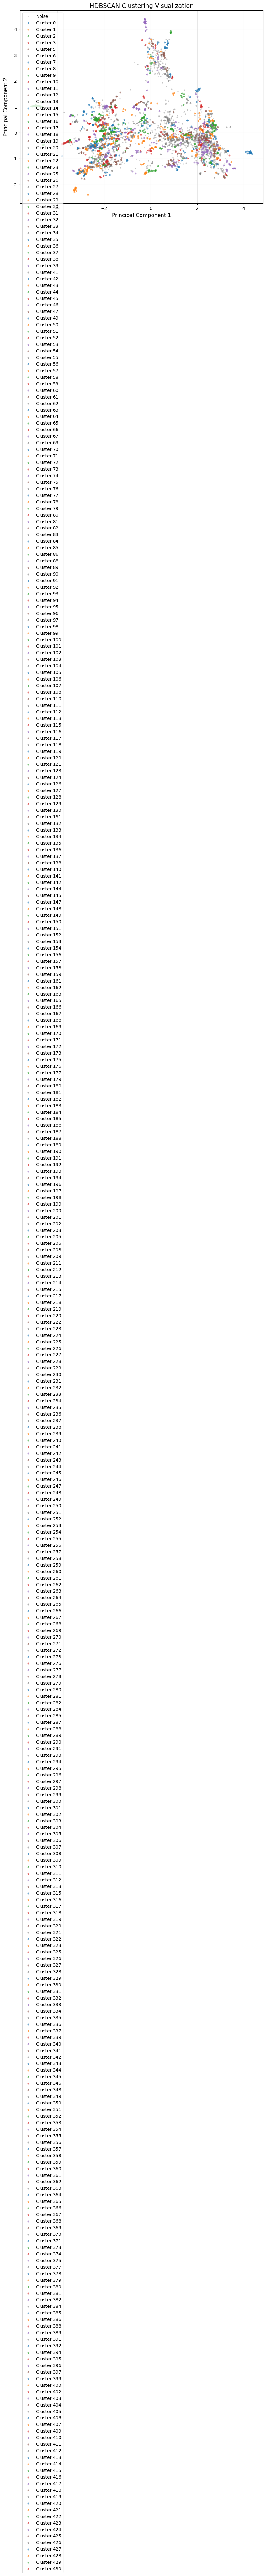

Current memory usage: 2.34 GB
Garbage collected: 94011 objects
Visualizing clusters and ground truth side-by-side...
Current memory usage: 2.34 GB
Current memory usage: 2.34 GB
Garbage collected: 0 objects


<ipython-input-9-a01e748272a5>:160: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Visualization completed in 2.11 seconds


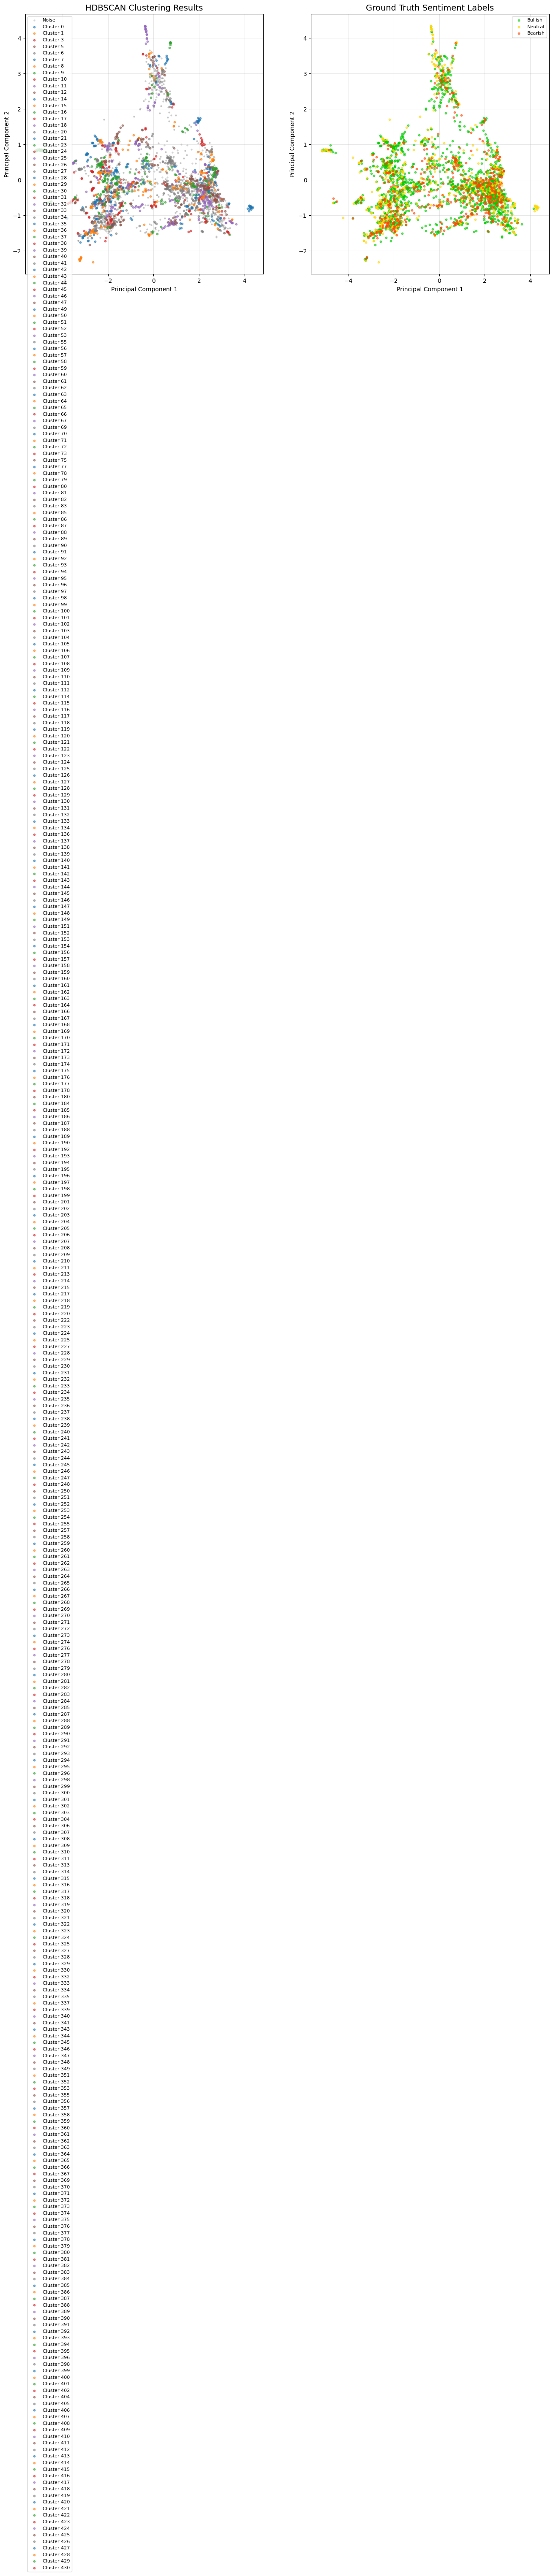

Current memory usage: 2.37 GB
Garbage collected: 18 objects


In [9]:
# Visualize clusters using PCA for 2D representation (memory efficient)
def visualize_clusters(embeddings, labels, max_points=3000):
    print("Visualizing clusters...")
    start_time = time.time()
    memory_status()

    # Sample data for visualization
    if len(embeddings) > max_points:
        indices = np.random.choice(len(embeddings), max_points, replace=False)
        sample_embeddings = embeddings[indices]
        sample_labels = labels[indices]
    else:
        sample_embeddings = embeddings
        sample_labels = labels

    # Reduce to 2D for visualization using PCA
    pca = PCA(n_components=2, random_state=42)
    reduced_data = pca.fit_transform(sample_embeddings)

    # Clear memory
    del sample_embeddings
    force_gc()

    # Create a scatter plot with custom colors
    plt.figure(figsize=(10, 8))

    # Define colors for the clusters
    colors = ['#7f7f7f', '#2077B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B']

    # Plot noise points first (if any)
    noise_mask = sample_labels == -1
    if np.any(noise_mask):
        plt.scatter(
            reduced_data[noise_mask, 0],
            reduced_data[noise_mask, 1],
            s=5,  # Smaller points
            c='#7f7f7f',
            alpha=0.3,
            label='Noise'
        )

    # Plot points for each cluster
    for label in sorted(set(sample_labels)):
        if label == -1:  # Skip noise points (already plotted)
            continue
        mask = sample_labels == label
        plt.scatter(
            reduced_data[mask, 0],
            reduced_data[mask, 1],
            s=10,  # Smaller points
            c=colors[(label+1) % len(colors)],
            alpha=0.6,
            label=f'Cluster {label}'
        )

    plt.title('HDBSCAN Clustering Visualization', fontsize=14)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)

    print(f"Visualization completed in {time.time() - start_time:.2f} seconds")
    plt.show()

    # Clear memory
    del reduced_data
    force_gc()

# Visualize clusters alongside ground truth
def visualize_clusters_with_ground_truth(embeddings, cluster_labels, true_labels, max_points=3000):
    print("Visualizing clusters and ground truth side-by-side...")
    start_time = time.time()
    memory_status()

    # Convert to numpy arrays if needed
    cluster_labels = np.array(cluster_labels)
    true_labels = np.array(true_labels)

    # Sample data for visualization
    if len(embeddings) > max_points:
        indices = np.random.choice(len(embeddings), max_points, replace=False)
        sample_embeddings = embeddings[indices]
        sample_cluster_labels = cluster_labels[indices]
        sample_true_labels = true_labels[indices]
    else:
        sample_embeddings = embeddings
        sample_cluster_labels = cluster_labels
        sample_true_labels = true_labels

    # Reduce to 2D for visualization using PCA
    pca = PCA(n_components=2, random_state=42)
    reduced_data = pca.fit_transform(sample_embeddings)

    # Clear memory
    del sample_embeddings
    force_gc()

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Define nice colors for the clusters
    cluster_colors = ['#7f7f7f', '#2077B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B']

    # Define colors for sentiment labels (Bullish, Neutral, Bearish)
    sentiment_colors = ['#00CC00', '#FFD700', '#FF4500']  # Green, Gold, Red-Orange
    sentiment_names = ["Bullish", "Neutral", "Bearish"]

    # Plot 1: Predicted Clusters
    # Plot noise points first (if any)
    noise_mask = sample_cluster_labels == -1
    if np.any(noise_mask):
        ax1.scatter(
            reduced_data[noise_mask, 0],
            reduced_data[noise_mask, 1],
            s=5,
            c='#7f7f7f',
            alpha=0.3,
            label='Noise'
        )

    # Plot points for each cluster
    for label in sorted(set(sample_cluster_labels)):
        if label == -1:  # Skip noise points (already plotted)
            continue
        mask = sample_cluster_labels == label
        ax1.scatter(
            reduced_data[mask, 0],
            reduced_data[mask, 1],
            s=10,
            c=cluster_colors[(label+1) % len(cluster_colors)],
            alpha=0.6,
            label=f'Cluster {label}'
        )

    ax1.set_title('HDBSCAN Clustering Results', fontsize=14)
    ax1.set_xlabel('Principal Component 1', fontsize=10)
    ax1.set_ylabel('Principal Component 2', fontsize=10)
    ax1.legend(loc='best', fontsize=8)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Ground Truth Sentiment Labels
    for label in sorted(set(sample_true_labels)):
        mask = sample_true_labels == label
        ax2.scatter(
            reduced_data[mask, 0],
            reduced_data[mask, 1],
            s=10,
            c=sentiment_colors[label % len(sentiment_colors)],
            alpha=0.6,
            label=sentiment_names[label]
        )

    ax2.set_title('Ground Truth Sentiment Labels', fontsize=14)
    ax2.set_xlabel('Principal Component 1', fontsize=10)
    ax2.set_ylabel('Principal Component 2', fontsize=10)
    ax2.legend(loc='best', fontsize=8)
    ax2.grid(True, alpha=0.3)

    # Adjust layout
    plt.tight_layout()
    print(f"Visualization completed in {time.time() - start_time:.2f} seconds")
    plt.show()

    # Clear memory
    del reduced_data
    force_gc()

# Visualize clusters
visualize_clusters(reduced_embeddings, cluster_labels)

# Visualize clusters alongside ground truth
visualize_clusters_with_ground_truth(reduced_embeddings, cluster_labels, true_labels)

Analyzing clusters in relation to true sentiment labels...
Current memory usage: 2.37 GB

Noise points analysis (9135 samples):
Bullish: 5662 samples (61.98%)
Neutral: 1605 samples (17.57%)
Bearish: 1868 samples (20.45%)
Dominant sentiment: Bullish (61.98%)

Cluster 0 analysis (32 samples):
Bullish: 15 samples (46.88%)
Neutral: 17 samples (53.12%)
Bearish: 0 samples (0.00%)
Dominant sentiment: Neutral (53.12%)

Cluster 1 analysis (10 samples):
Bullish: 2 samples (20.00%)
Neutral: 8 samples (80.00%)
Bearish: 0 samples (0.00%)
Dominant sentiment: Neutral (80.00%)

Cluster 2 analysis (14 samples):
Bullish: 14 samples (100.00%)
Neutral: 0 samples (0.00%)
Bearish: 0 samples (0.00%)
Dominant sentiment: Bullish (100.00%)

Cluster 3 analysis (97 samples):
Bullish: 60 samples (61.86%)
Neutral: 19 samples (19.59%)
Bearish: 18 samples (18.56%)
Dominant sentiment: Bullish (61.86%)

Cluster 4 analysis (14 samples):
Bullish: 4 samples (28.57%)
Neutral: 10 samples (71.43%)
Bearish: 0 samples (0.00%)


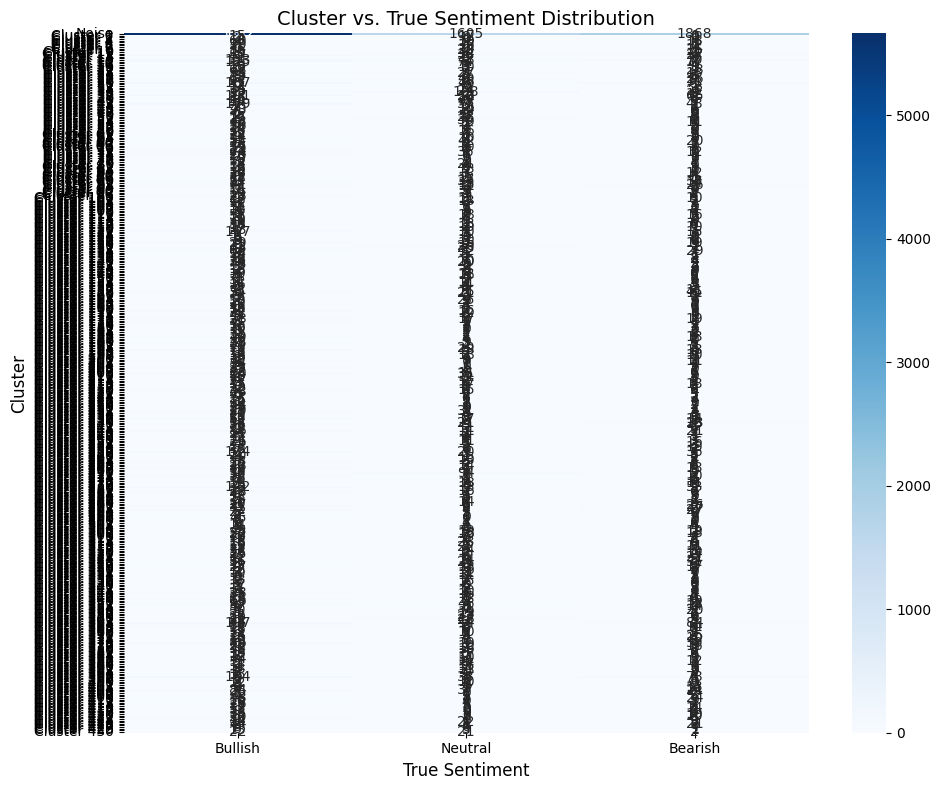


Proposed cluster-to-sentiment mapping:
Cluster 0 → Neutral
Cluster 1 → Neutral
Cluster 2 → Bullish
Cluster 3 → Bullish
Cluster 4 → Neutral
Cluster 5 → Bullish
Cluster 6 → Bullish
Cluster 7 → Bullish
Cluster 8 → Neutral
Cluster 9 → Bullish
Cluster 10 → Bullish
Cluster 11 → Neutral
Cluster 12 → Bullish
Cluster 13 → Bullish
Cluster 14 → Bullish
Cluster 15 → Bullish
Cluster 16 → Bullish
Cluster 17 → Bullish
Cluster 18 → Bullish
Cluster 19 → Bullish
Cluster 20 → Bullish
Cluster 21 → Bullish
Cluster 22 → Bullish
Cluster 23 → Bullish
Cluster 24 → Neutral
Cluster 25 → Bullish
Cluster 26 → Bullish
Cluster 27 → Bullish
Cluster 28 → Bullish
Cluster 29 → Bullish
Cluster 30 → Neutral
Cluster 31 → Bullish
Cluster 32 → Bullish
Cluster 33 → Bullish
Cluster 34 → Bullish
Cluster 35 → Neutral
Cluster 36 → Bullish
Cluster 37 → Bullish
Cluster 38 → Bullish
Cluster 39 → Bullish
Cluster 40 → Bullish
Cluster 41 → Bullish
Cluster 42 → Bullish
Cluster 43 → Bullish
Cluster 44 → Neutral
Cluster 45 → Bullish
Clus

In [10]:
# Analyze clusters in relation to true sentiment labels (memory efficient)
def analyze_clusters(cluster_labels, true_labels):
    print("Analyzing clusters in relation to true sentiment labels...")
    memory_status()

    # Convert to numpy arrays for easier manipulation
    cluster_labels = np.array(cluster_labels)
    true_labels = np.array(true_labels)

    # Define sentiment names for readability
    sentiment_names = {0: "Bullish", 1: "Neutral", 2: "Bearish"}

    # Analyze each cluster
    clusters = sorted(set(cluster_labels))

    # Create a confusion matrix-like structure
    n_sentiments = len(sentiment_names)
    conf_matrix = np.zeros((len(clusters), n_sentiments), dtype=int)

    for i, cluster in enumerate(clusters):
        # Get indices of tweets in this cluster
        cluster_indices = np.where(cluster_labels == cluster)[0]

        # Get the true sentiments for these tweets
        cluster_true_sentiments = true_labels[cluster_indices]

        # Count sentiment distribution
        sentiment_counts = Counter(cluster_true_sentiments)
        total = len(cluster_indices)

        if cluster == -1:
            print(f"\nNoise points analysis ({total} samples):")
        else:
            print(f"\nCluster {cluster} analysis ({total} samples):")

        for sentiment in range(n_sentiments):
            count = sentiment_counts.get(sentiment, 0)
            conf_matrix[i, sentiment] = count
            percentage = (count/total*100) if total > 0 else 0
            print(f"{sentiment_names[sentiment]}: {count} samples ({percentage:.2f}%)")

        # Find the dominant sentiment (if any samples in cluster)
        if total > 0:
            dominant_sentiment = max(sentiment_counts.items(), key=lambda x: x[1])[0]
            dominant_percent = sentiment_counts[dominant_sentiment] / total * 100
            print(f"Dominant sentiment: {sentiment_names[dominant_sentiment]} ({dominant_percent:.2f}%)")

    # Calculate metrics (excluding noise points)
    if -1 in clusters:
        # Calculate metrics only for non-noise points
        non_noise_mask = cluster_labels != -1
        if np.sum(non_noise_mask) > 0:  # Make sure there are non-noise points
            ari = adjusted_rand_score(true_labels[non_noise_mask], cluster_labels[non_noise_mask])
            nmi = normalized_mutual_info_score(true_labels[non_noise_mask], cluster_labels[non_noise_mask])
            print(f"\nMetrics (excluding noise points):")
            print(f"Adjusted Rand Index: {ari:.4f}")
            print(f"Normalized Mutual Information: {nmi:.4f}")

    # Calculate metrics for all points
    ari_all = adjusted_rand_score(true_labels, cluster_labels)
    nmi_all = normalized_mutual_info_score(true_labels, cluster_labels)
    print(f"\nMetrics (including noise points):")
    print(f"Adjusted Rand Index: {ari_all:.4f}")
    print(f"Normalized Mutual Information: {nmi_all:.4f}")

    # Visualize the confusion matrix
    plt.figure(figsize=(10, 8))

    # Create labels for clusters
    cluster_labels_str = []
    for cluster in clusters:
        if cluster == -1:
            cluster_labels_str.append("Noise")
        else:
            cluster_labels_str.append(f"Cluster {cluster}")

    # Create heatmap
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=[sentiment_names[i] for i in range(n_sentiments)],
        yticklabels=cluster_labels_str
    )
    plt.xlabel('True Sentiment', fontsize=12)
    plt.ylabel('Cluster', fontsize=12)
    plt.title('Cluster vs. True Sentiment Distribution', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Attempt to map clusters to sentiments (excluding noise)
    cluster_to_sentiment = {}
    for i, cluster in enumerate(clusters):
        if cluster != -1:  # Skip noise
            dominant_sentiment = np.argmax(conf_matrix[i])
            cluster_to_sentiment[cluster] = dominant_sentiment

    print("\nProposed cluster-to-sentiment mapping:")
    for cluster, sentiment in cluster_to_sentiment.items():
        print(f"Cluster {cluster} → {sentiment_names[sentiment]}")

    return cluster_to_sentiment

# Analyze clusters
cluster_to_sentiment = analyze_clusters(cluster_labels, true_labels)
force_gc()  # Free memory

Visualizing clusters grouped by sentiment...
Current memory usage: 2.37 GB


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Visualization completed in 34.63 seconds


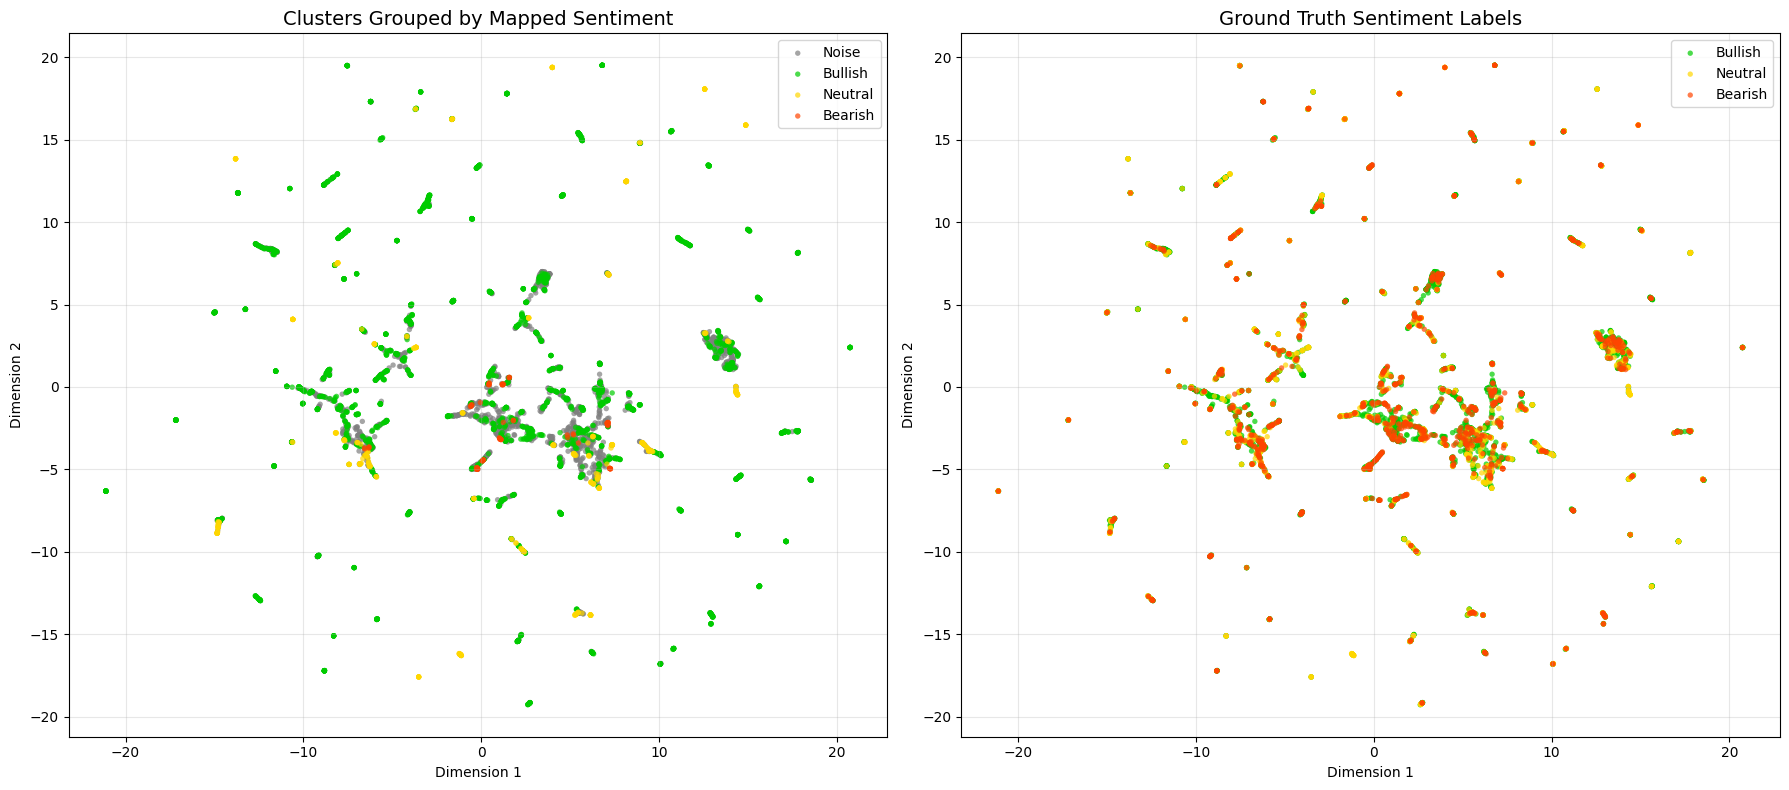


Distribution of clusters by mapped sentiment:
Bullish: 350 clusters (81.0%)
Neutral: 64 clusters (14.8%)
Bearish: 17 clusters (3.9%)


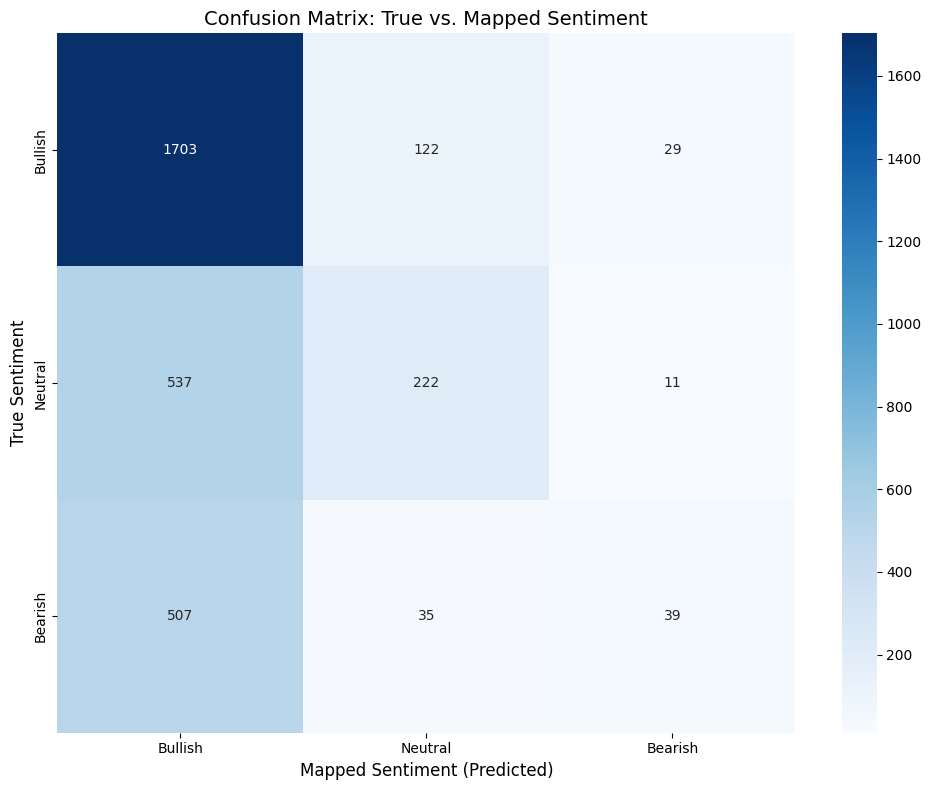

Current memory usage: 2.37 GB
Garbage collected: 27949 objects


In [11]:
def visualize_sentiment_grouped_clusters(embeddings, cluster_labels, true_labels, cluster_to_sentiment, max_points=5000):
    """
    Visualize clusters grouped by their mapped sentiment, compared to ground truth.
    """
    print("Visualizing clusters grouped by sentiment...")
    start_time = time.time()
    memory_status()

    # Convert to numpy arrays
    cluster_labels = np.array(cluster_labels)
    true_labels = np.array(true_labels)

    # Sample data for visualization
    if len(embeddings) > max_points:
        indices = np.random.choice(len(embeddings), max_points, replace=False)
        sample_embeddings = embeddings[indices]
        sample_cluster_labels = cluster_labels[indices]
        sample_true_labels = true_labels[indices]
    else:
        sample_embeddings = embeddings
        sample_cluster_labels = cluster_labels
        sample_true_labels = true_labels

    # Map clusters to their sentiment
    mapped_sentiment = np.zeros_like(sample_cluster_labels)
    for i, cluster in enumerate(sample_cluster_labels):
        if cluster == -1:
            mapped_sentiment[i] = -1  # Noise
        else:
            mapped_sentiment[i] = cluster_to_sentiment.get(cluster, -1)

    # Reduce to 2D for visualization using UMAP for better separation
    try:
        import umap
        reducer = umap.UMAP(
            n_components=2,
            random_state=42,
            n_neighbors=15,
            min_dist=0.1
        )
        reduced_data = reducer.fit_transform(sample_embeddings)
    except:
        # Fall back to PCA if UMAP fails
        from sklearn.decomposition import PCA
        reducer = PCA(n_components=2, random_state=42)
        reduced_data = reducer.fit_transform(sample_embeddings)

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    # Define colors for sentiment labels
    sentiment_colors = {
        -1: '#7f7f7f',  # Gray for noise
        0: '#00CC00',   # Green for Bullish
        1: '#FFD700',   # Gold for Neutral
        2: '#FF4500'    # Red-Orange for Bearish
    }
    sentiment_names = {-1: "Noise", 0: "Bullish", 1: "Neutral", 2: "Bearish"}

    # Plot 1: Grouped by mapped sentiment
    for sentiment in sorted(set(mapped_sentiment)):
        mask = mapped_sentiment == sentiment
        ax1.scatter(
            reduced_data[mask, 0],
            reduced_data[mask, 1],
            s=15,
            c=sentiment_colors[sentiment],
            alpha=0.7,
            label=sentiment_names[sentiment],
            edgecolors='none'  # Remove edges for cleaner look
        )

    ax1.set_title('Clusters Grouped by Mapped Sentiment', fontsize=14)
    ax1.set_xlabel('Dimension 1', fontsize=10)
    ax1.set_ylabel('Dimension 2', fontsize=10)
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Ground Truth Sentiment Labels
    for label in sorted(set(sample_true_labels)):
        mask = sample_true_labels == label
        ax2.scatter(
            reduced_data[mask, 0],
            reduced_data[mask, 1],
            s=15,
            c=sentiment_colors[label],
            alpha=0.7,
            label=sentiment_names[label],
            edgecolors='none'
        )

    ax2.set_title('Ground Truth Sentiment Labels', fontsize=14)
    ax2.set_xlabel('Dimension 1', fontsize=10)
    ax2.set_ylabel('Dimension 2', fontsize=10)
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3)

    # Adjust layout
    plt.tight_layout()
    plt.savefig('sentiment_comparison.png', dpi=300, bbox_inches='tight')
    print(f"Visualization completed in {time.time() - start_time:.2f} seconds")
    plt.show()

    # Create additional analysis
    # Count distribution of clusters by sentiment
    print("\nDistribution of clusters by mapped sentiment:")
    unique_clusters = set(cluster_labels)
    sentiment_counts = {0: 0, 1: 0, 2: 0}  # Bullish, Neutral, Bearish

    for cluster in unique_clusters:
        if cluster != -1:  # Skip noise
            sentiment = cluster_to_sentiment.get(cluster, -1)
            if sentiment in sentiment_counts:
                sentiment_counts[sentiment] += 1

    for sentiment, count in sentiment_counts.items():
        print(f"{sentiment_names[sentiment]}: {count} clusters ({count/len(unique_clusters)*100:.1f}%)")

    # Calculate confusion matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    # Filter out noise points for confusion matrix
    non_noise_mask = mapped_sentiment != -1
    if sum(non_noise_mask) > 0:
        conf_mat = confusion_matrix(
            sample_true_labels[non_noise_mask],
            mapped_sentiment[non_noise_mask],
            labels=[0, 1, 2]
        )

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            conf_mat,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=["Bullish", "Neutral", "Bearish"],
            yticklabels=["Bullish", "Neutral", "Bearish"]
        )
        plt.xlabel('Mapped Sentiment (Predicted)', fontsize=12)
        plt.ylabel('True Sentiment', fontsize=12)
        plt.title('Confusion Matrix: True vs. Mapped Sentiment', fontsize=14)
        plt.tight_layout()
        plt.savefig('sentiment_confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()

    # Clear memory
    del reduced_data
    force_gc()

# Use this function with your existing data
visualize_sentiment_grouped_clusters(reduced_embeddings, cluster_labels, true_labels, cluster_to_sentiment)

Investigating sentiment mapping issues...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


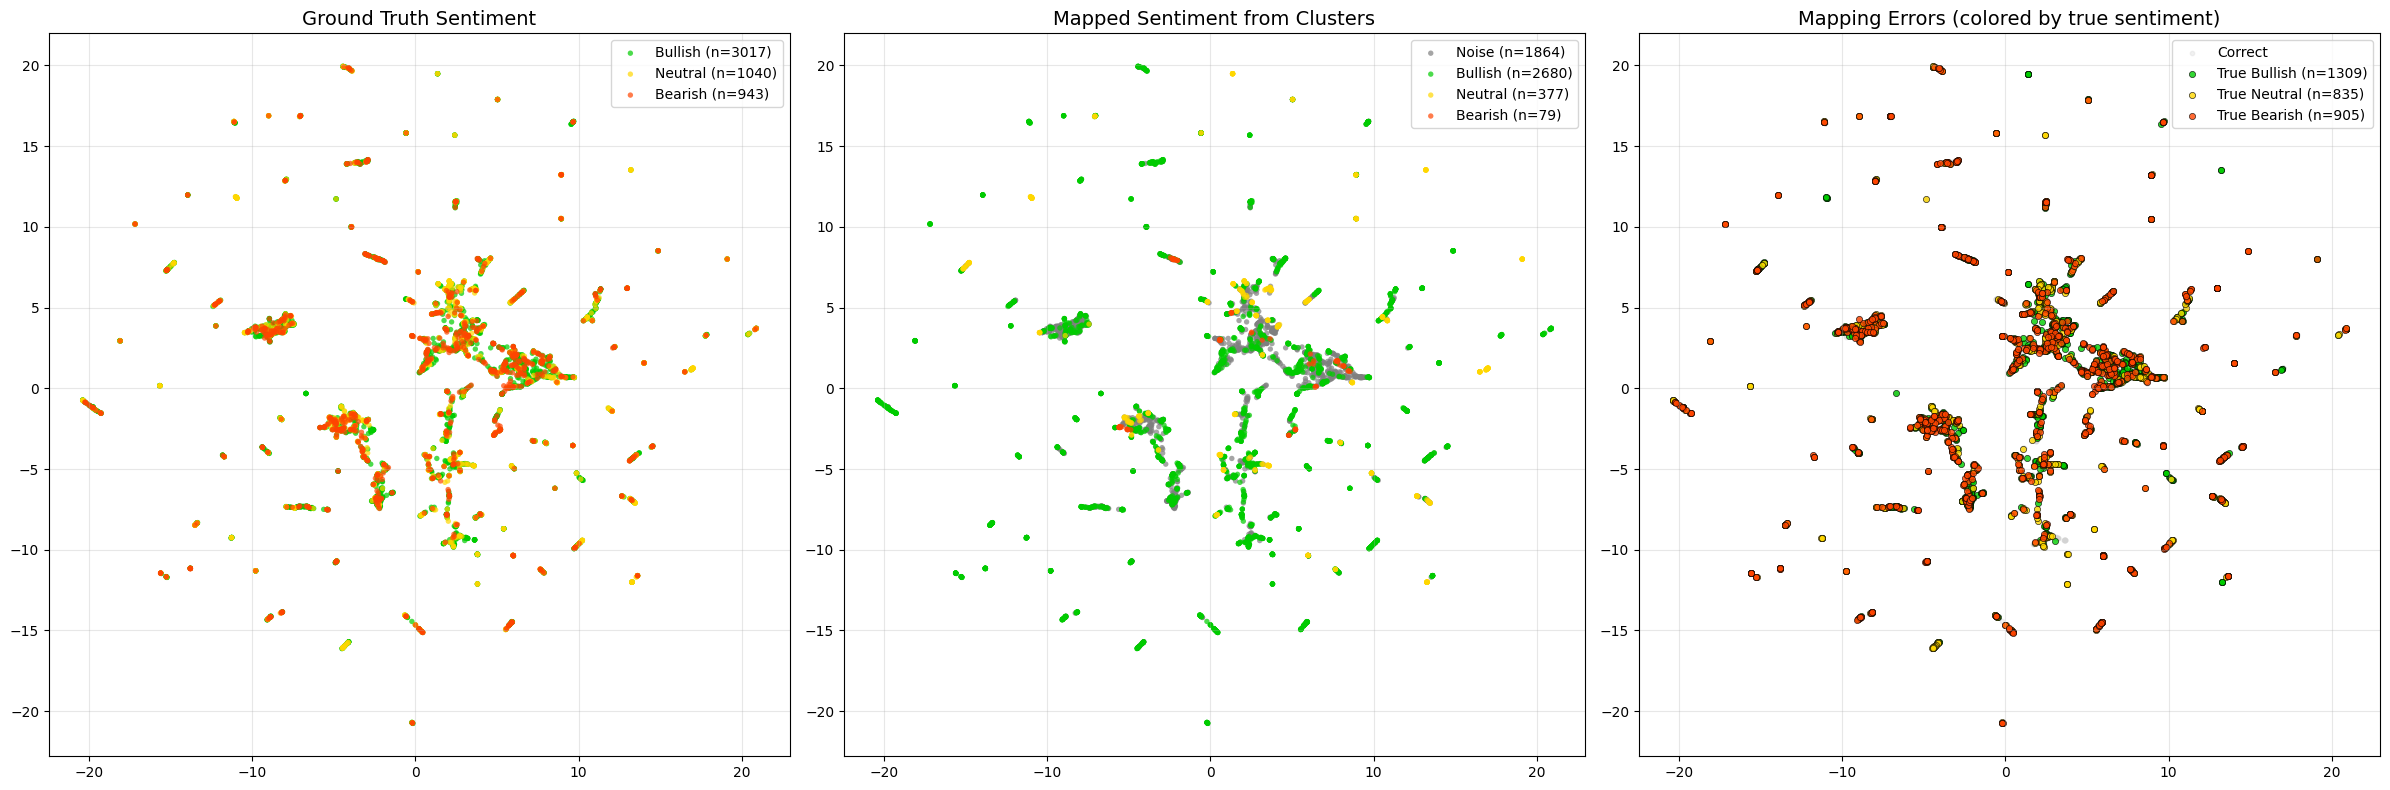


Sentiment distribution analysis:

Ground truth sentiment distribution:
Bullish: 3017 samples (60.3%)
Neutral: 1040 samples (20.8%)
Bearish: 943 samples (18.9%)

Mapped sentiment distribution:
Noise: 1864 samples (37.3%)
Bullish: 2680 samples (53.6%)
Neutral: 377 samples (7.5%)
Bearish: 79 samples (1.6%)

Confusion Matrix:
[[1708  140   32]
 [ 491  205    9]
 [ 481   32   38]]
Accuracy for Bullish: 90.9% (1708/1880)
Accuracy for Neutral: 29.1% (205/705)
Accuracy for Bearish: 6.9% (38/551)

Overall accuracy: 39.0%


In [12]:
def investigate_sentiment_mapping_issue(embeddings, cluster_labels, true_labels, cluster_to_sentiment, max_points=5000):
    """
    Create a visualization that highlights the potential mapping problem
    """
    print("Investigating sentiment mapping issues...")

    # Convert to arrays and sample
    cluster_labels = np.array(cluster_labels)
    true_labels = np.array(true_labels)

    if len(embeddings) > max_points:
        indices = np.random.choice(len(embeddings), max_points, replace=False)
        sample_embeddings = embeddings[indices]
        sample_cluster_labels = cluster_labels[indices]
        sample_true_labels = true_labels[indices]
    else:
        sample_embeddings = embeddings
        sample_cluster_labels = cluster_labels
        sample_true_labels = true_labels

    # Map clusters to their sentiment
    mapped_sentiment = np.zeros_like(sample_cluster_labels)
    for i, cluster in enumerate(sample_cluster_labels):
        if cluster == -1:
            mapped_sentiment[i] = -1  # Noise
        else:
            mapped_sentiment[i] = cluster_to_sentiment.get(cluster, -1)

    # Use UMAP for better visualization
    import umap
    reducer = umap.UMAP(n_components=2, random_state=42, min_dist=0.1)
    reduced_data = reducer.fit_transform(sample_embeddings)

    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    # Define colors
    sentiment_colors = {
        -1: '#7f7f7f',  # Gray for noise
        0: '#00CC00',   # Green for Bullish
        1: '#FFD700',   # Gold for Neutral
        2: '#FF4500'    # Red-Orange for Bearish
    }
    sentiment_names = {-1: "Noise", 0: "Bullish", 1: "Neutral", 2: "Bearish"}

    # Plot 1: Ground Truth
    for label in sorted(set(sample_true_labels)):
        mask = sample_true_labels == label
        axes[0].scatter(
            reduced_data[mask, 0],
            reduced_data[mask, 1],
            s=15, c=sentiment_colors[label], alpha=0.7,
            label=f"{sentiment_names[label]} (n={np.sum(mask)})",
            edgecolors='none'
        )
    axes[0].set_title('Ground Truth Sentiment', fontsize=14)
    axes[0].legend(loc='best')
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Mapped Sentiment
    for label in sorted(set(mapped_sentiment)):
        mask = mapped_sentiment == label
        axes[1].scatter(
            reduced_data[mask, 0],
            reduced_data[mask, 1],
            s=15, c=sentiment_colors[label], alpha=0.7,
            label=f"{sentiment_names[label]} (n={np.sum(mask)})",
            edgecolors='none'
        )
    axes[1].set_title('Mapped Sentiment from Clusters', fontsize=14)
    axes[1].legend(loc='best')
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Mapping Errors
    correct_mask = mapped_sentiment == sample_true_labels
    incorrect_mask = ~correct_mask

    # Plot correct ones in light gray
    axes[2].scatter(
        reduced_data[correct_mask, 0],
        reduced_data[correct_mask, 1],
        s=10, c='lightgray', alpha=0.3, label='Correct')

    # Plot incorrect ones with their true label colors
    for label in sorted(set(sample_true_labels)):
        if label != -1:  # Skip noise
            mask = (sample_true_labels == label) & incorrect_mask
            if np.sum(mask) > 0:
                axes[2].scatter(
                    reduced_data[mask, 0],
                    reduced_data[mask, 1],
                    s=20, c=sentiment_colors[label], alpha=0.8,
                    label=f"True {sentiment_names[label]} (n={np.sum(mask)})",
                    edgecolors='black', linewidth=0.5
                )

    axes[2].set_title('Mapping Errors (colored by true sentiment)', fontsize=14)
    axes[2].legend(loc='best')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('sentiment_mapping_investigation.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print statistics
    print("\nSentiment distribution analysis:")

    print("\nGround truth sentiment distribution:")
    for sentiment in sorted(set(sample_true_labels)):
        count = np.sum(sample_true_labels == sentiment)
        print(f"{sentiment_names[sentiment]}: {count} samples ({count/len(sample_true_labels)*100:.1f}%)")

    print("\nMapped sentiment distribution:")
    for sentiment in sorted(set(mapped_sentiment)):
        count = np.sum(mapped_sentiment == sentiment)
        print(f"{sentiment_names[sentiment]}: {count} samples ({count/len(mapped_sentiment)*100:.1f}%)")

    # Confusion matrix
    from sklearn.metrics import confusion_matrix

    non_noise_mask = (mapped_sentiment != -1) & (sample_true_labels != -1)
    if sum(non_noise_mask) > 0:
        conf_mat = confusion_matrix(
            sample_true_labels[non_noise_mask],
            mapped_sentiment[non_noise_mask],
            labels=[0, 1, 2]
        )

        print("\nConfusion Matrix:")
        print(conf_mat)

        # Accuracy by sentiment
        for i, sentiment in enumerate([0, 1, 2]):
            true_count = np.sum(sample_true_labels[non_noise_mask] == sentiment)
            correct_count = conf_mat[i, i]
            if true_count > 0:
                accuracy = correct_count / true_count * 100
                print(f"Accuracy for {sentiment_names[sentiment]}: {accuracy:.1f}% ({correct_count}/{true_count})")

    # Calculate overall accuracy
    overall_accuracy = np.mean(mapped_sentiment == sample_true_labels) * 100
    print(f"\nOverall accuracy: {overall_accuracy:.1f}%")

# Use this function with your existing data
investigate_sentiment_mapping_issue(reduced_embeddings, cluster_labels, true_labels, cluster_to_sentiment)